# Laboratorio 4 — Clasificación de Imágenes con CNN (CIFAR-10)
- **Data Science:**    
- **Rodrigo Mansilla 22611**
-  
- **8/22/2025**   



## 1. Preparación del conjunto de datos (10 pts)



### 1.1 Importación y carga del dataset  

In [1]:
# Manejo de datos y utilidades
import numpy as np
import matplotlib.pyplot as plt

# Librerías de deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Dataset CIFAR-10 incluido en Keras
from tensorflow.keras.datasets import cifar10

# Para métricas y reportes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Cargar datos de Keras (ya viene incluido)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print("Tamaño de entrenamiento:", x_train.shape, y_train.shape)
print("Tamaño de prueba:", x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 269s 2us/step
Tamaño de entrenamiento: (50000, 32, 32, 3) (50000, 1)
Tamaño de prueba: (10000, 32, 32, 3) (10000, 1)


### 1.2 Normalización de datos  


In [3]:
# Escalar valores de píxeles de 0–255 a rango [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Confirmar rango de valores
print("Rango de entrenamiento:", x_train.min(), "→", x_train.max())
print("Rango de prueba:", x_test.min(), "→", x_test.max())

Rango de entrenamiento: 0.0 → 1.0
Rango de prueba: 0.0 → 1.0


### 1.3 Visualización de ejemplos  


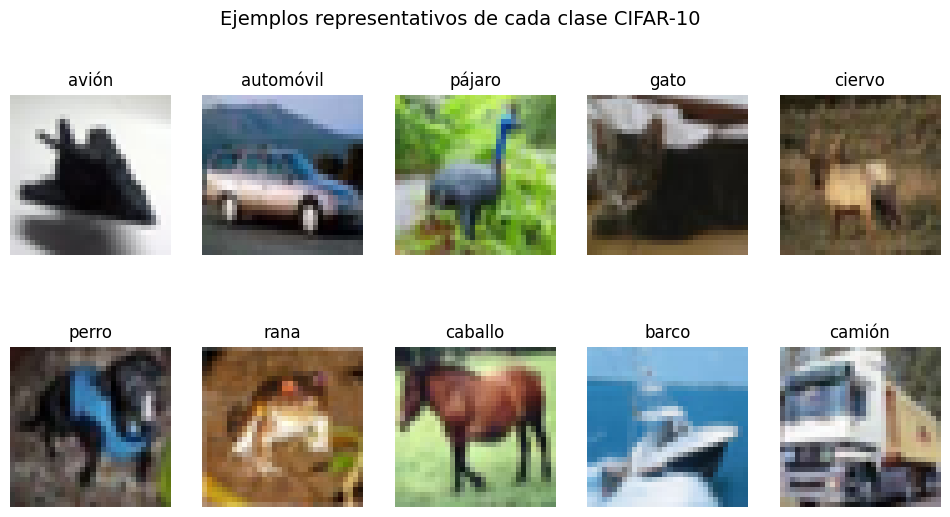

In [5]:


class_names = [
    "avión", "automóvil", "pájaro", "gato", "ciervo",
    "perro", "rana", "caballo", "barco", "camión"
]

sample_indices = []
for class_id in range(10):
    idx = np.where(y_train.flatten() == class_id)[0][0]
    sample_indices.append(idx)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx][0]])
    plt.axis("off")

plt.suptitle("Ejemplos representativos de cada clase CIFAR-10", fontsize=14)
plt.show()


### Documentación — Paso 1: Preparación del Conjunto de Datos

El conjunto de datos **CIFAR-10** tiene  **60,000 imágenes a color de 32×32 píxeles**, distribuidas en **10 clases** balanceadas (avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión).  

- **División de datos:**  
  - 50,000 imágenes para **entrenamiento**  
  - 10,000 imágenes para **prueba**  

- **Dimensiones:**  
  - `x_train`: (50000, 32, 32, 3) — imágenes RGB de entrenamiento  
  - `y_train`: (50000, 1) — etiquetas numéricas [0–9]  
  - `x_test`: (10000, 32, 32, 3) — imágenes de prueba  
  - `y_test`: (10000, 1) — etiquetas numéricas [0–9]  

- **Normalización:**  
  Los valores de píxel (0–255) se escalaron al rango **[0, 1]**, para  estabilidad numérica durante el entrenamiento.

- **Visualización:**  
  Se muestran **ejemplos representativos (1 por clase)** para verificar la  correspondencia entre imágenes y etiquetas. 


## 2. Modelo base ANN (10 pts)


### 2.1 Arquitectura ANN  

In [20]:
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
import numpy as np

mean = x_train.mean(axis=(0,1,2), keepdims=True)
std  = x_train.std(axis=(0,1,2), keepdims=True) + 1e-7
x_train_s = (x_train - mean) / std
x_test_s  = (x_test  - mean) / std

ann_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),

    Dense(1024, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(512, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),

    Dense(10, activation="softmax")
])

ann_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  # un poco menor para estabilidad
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### 2.2 Entrenamiento

In [23]:

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    filepath="best_ann.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

# ---- Entrenamiento ----
history = ann_model.fit(
    x_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_sched, ckpt],
    verbose=2
)




Epoch 1/100
625/625 - 33s - 53ms/step - accuracy: 0.3423 - loss: 2.1379 - val_accuracy: 0.4264 - val_loss: 1.8574 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 - 31s - 49ms/step - accuracy: 0.4166 - loss: 1.8936 - val_accuracy: 0.4556 - val_loss: 1.7623 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 - 31s - 49ms/step - accuracy: 0.4539 - loss: 1.7807 - val_accuracy: 0.4778 - val_loss: 1.7035 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 - 31s - 49ms/step - accuracy: 0.4760 - loss: 1.7121 - val_accuracy: 0.4846 - val_loss: 1.6783 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 - 31s - 49ms/step - accuracy: 0.4978 - loss: 1.6502 - val_accuracy: 0.5031 - val_loss: 1.6304 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 - 31s - 50ms/step - accuracy: 0.5125 - loss: 1.6001 - val_accuracy: 0.5063 - val_loss: 1.6138 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 - 31s - 50ms/step - accuracy: 0.5260 - loss: 1.5595 - val_accuracy: 0.5177 - val_loss: 1.6031 - learning_rate: 3.0000e-04
Epoch 

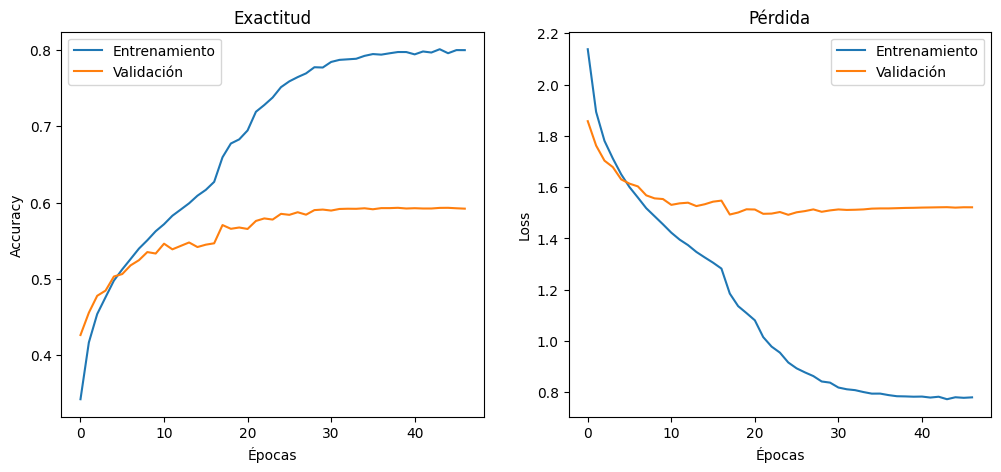

In [24]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 2.3 Resultados y observaciones  


## Resultados — Modelo ANN (Baseline Denso)

##### 1) Configuración experimental (resumen)
- **Arquitectura (ANN):** `Flatten → Dense(1024) → Dense(512) → Dense(256) → Softmax(10)`
  - Activación: **LeakyReLU (α=0.01)** en capas ocultas.
  - **BatchNormalization** tras cada capa densa.
  - **Dropout:** 0.30, 0.30 y 0.25 (respectivamente).
  - **Regularización L2:** 1e-4 en capas densas.
- **Entrenamiento:** Adam (lr=3e-4), pérdida `SparseCategoricalCrossentropy`,
  `ReduceLROnPlateau` (factor=0.5, patience=3, min_lr=1e-6),
  `EarlyStopping` (monitor=`val_accuracy`, patience=10, `restore_best_weights=True`),
  **batch_size=64**, máx. 100 épocas, split de validación 0.2.

---

##### 2) Métricas  observadas
| Métrica                         | Valor aproximado |
|---------------------------------|------------------|
| Accuracy (entrenamiento)        | **0.80** (ép. ~46) |
| Accuracy (validación)           | **0.5925** (ép. 46) |
| Loss (validación)               | **~1.52** (meseta) |
| Learning rate final (scheduler) | **1e-6** |

> Evidencia de entrenamiento: incremento sostenido de accuracy en train y
> meseta en validación a partir de las épocas 10–15; `val_loss` estable (~1.5).

---

##### 3) Interpretación 
- **Generalización limitada / sobreajuste moderado:** la red alcanza ~0.80 en entrenamiento pero
  se estanca en ~0.59 en validación. La brecha indica que el modelo aprende patrones
  específicos del conjunto de entrenamiento.
- **Limitación estructural de ANN en visión:** al aplicar `Flatten`, se pierde la estructura
  espacial. En CIFAR-10, las ANN densas  saturaN en ~55–60% sin técnicas adicionales.

---
##### 5) Cuellos de botella
- **Capacidad sin sesgo inductivo espacial:** más neuronas/capas aumentan la memorización,
  no la generalización, al no modelar relaciones locales de píxeles.
- **Meseta de validación con LR mínimo:** el scheduler reduce el LR hasta 1e-6,
  pero no hay mejora adicional.

---

#####  Conclusión
El modelo ANN denso entrega un **baseline válido** en CIFAR-10 ,
coherente con las limitaciones esperadas para arquitecturas totalmente conectadas en visión.


## 3. Implementación de CNN


### 3.1 Definición de la arquitectura  


In [ ]:
# 3.1 Definición de la arquitectura — ANN baseline robusta
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU

ann_model = Sequential(name="ANN_baseline_robusta")

# Entrada
ann_model.add(Flatten(input_shape=(32, 32, 3), name="flatten"))

# Bloque denso 1
ann_model.add(Dense(1024, kernel_regularizer=regularizers.l2(1e-4), name="dense_1"))
ann_model.add(BatchNormalization(name="bn_1"))
ann_model.add(LeakyReLU(alpha=0.01, name="lrelu_1"))
ann_model.add(Dropout(0.30, name="dropout_1"))

# Bloque denso 2
ann_model.add(Dense(512, kernel_regularizer=regularizers.l2(1e-4), name="dense_2"))
ann_model.add(BatchNormalization(name="bn_2"))
ann_model.add(LeakyReLU(alpha=0.01, name="lrelu_2"))
ann_model.add(Dropout(0.30, name="dropout_2"))

# Bloque denso 3
ann_model.add(Dense(256, kernel_regularizer=regularizers.l2(1e-4), name="dense_3"))
ann_model.add(BatchNormalization(name="bn_3"))
ann_model.add(LeakyReLU(alpha=0.01, name="lrelu_3"))
ann_model.add(Dropout(0.25, name="dropout_3"))

# Salida
ann_model.add(Dense(10, activation="softmax", name="predicciones"))

ann_model.summary()


### 3.2 Justificación de decisiones  


### 3.3 Regularización y callbacks  


### 3.4 Entrenamiento y resultados  
 

## 4. Evaluación y comparación (20 pts)


### 4.1 Curvas de aprendizaje (ANN vs CNN)  

### 4.2 Evaluación en test  

### 4.3 Matriz de confusión 

### 4.4 Ejemplos de errores   

### 4.5 Análisis comparativo  


## 5. Reflexión crítica 

### 5.1 Comparación ANN vs CNN  


### 5.2 Rol de convoluciones y pooling  


### 5.3 Posibles mejoras  

## Data Augmentation